In [6]:
pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 1.9 MB/s eta 0:00:003.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Training classification head...
Epoch 1/10 - train_loss: 0.6817, train_acc: 0.5816, val_loss: 0.6606, val_acc: 0.8243
Epoch 2/10 - train_loss: 0.6802, train_acc: 0.5578, val_loss: 0.6577, val_acc: 0.6351
Epoch 3/10 - train_loss: 0.6792, train_acc: 0.5816, val_loss: 0.6907, val_acc: 0.5541
Epoch 4/10 - train_loss: 0.6767, train_acc: 0.5680, val_loss: 0.6939, val_acc: 0.5541
Epoch 5/10 - train_loss: 0.6823, train_acc: 0.5884, val_loss: 0.6999, val_acc: 0.5135
Epoch 6/10 - train_loss: 0.6823, train_acc: 0.5748, val_loss: 0.6939, val_acc: 0.5270
Epoch 7/10 - train_loss: 0.6817, train_acc: 0.5884, val_loss: 0.6906, val_acc: 0.6081
Epoch 8/10 - train_loss: 0.6781, train_acc: 0.6122, val_loss: 0.6905, val_acc: 0.5811
Epoch 9/10 - train_loss: 0.6778, train_acc: 0.6020, val_loss: 0.6955, val_acc: 0.5541
Epoch 10/10 - train_loss: 0.6804, train_acc: 0.6088, val_loss: 0.6967, val_acc: 0.5405
Fine-tuning the entire model...
Epoch 1/10 - train_loss: 0.6079, train_acc: 0.8639, val_loss: 0.5531, val_a

/home/fast/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


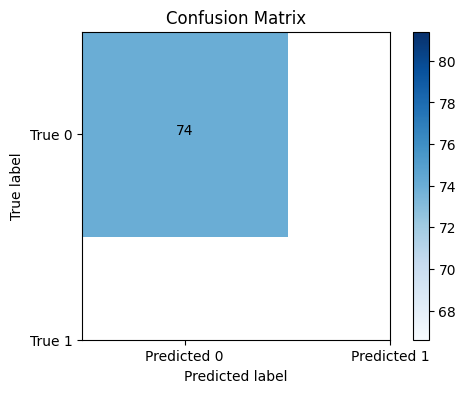

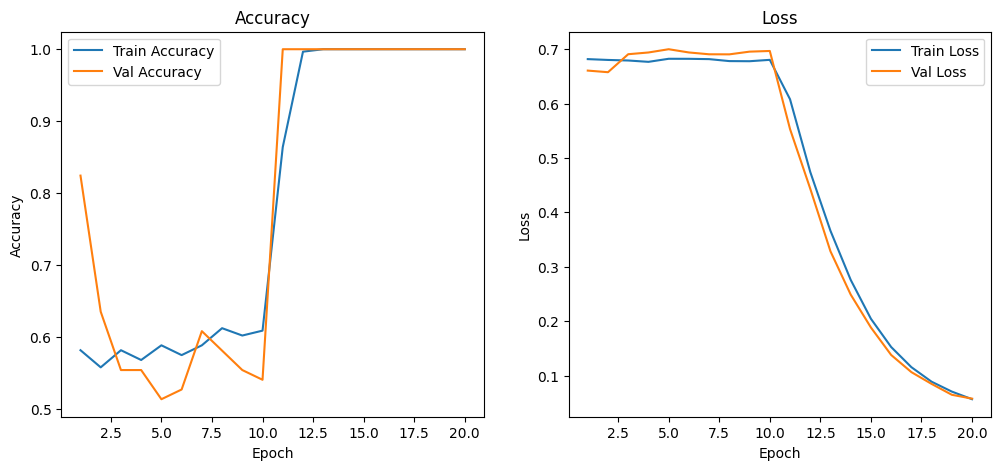

In [3]:
import os
import glob
import nibabel as nib
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import timm
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Configuration
IMG_HEIGHT, IMG_WIDTH = 300, 300
BATCH_SIZE = 8
EPOCHS_HEAD = 10
EPOCHS_FINE = 10
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FINE = 1e-5
ROOT_DIR = '/media/fast/New Volume/Asim/archive(1)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset
class BratsDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        fp = self.file_paths[idx]
        ext = os.path.splitext(fp)[1].lower()

        # Load and preprocess
        if ext in ['.nii', '.gz']:
            nii = nib.load(fp)
            data = nii.get_fdata()
            mask = (data > 0).astype(np.float32)
            slice_ = mask[:, :, mask.shape[2] // 2]
            img = cv2.resize(slice_, (IMG_WIDTH, IMG_HEIGHT))
            img = np.stack([img] * 3, axis=2)
        else:
            img_bgr = cv2.imread(fp, cv2.IMREAD_COLOR)
            if img_bgr is None:
                raise ValueError(f"Cannot read {fp}")
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img_rgb, (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0

        # To tensor and normalize
        img = torch.from_numpy(img.transpose((2, 0, 1))).float()
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

# Gather file paths and labels
file_paths = glob.glob(os.path.join(ROOT_DIR, 'BraTS20_Training_*', '*_seg.nii'))
file_paths += glob.glob(os.path.join(ROOT_DIR, 'BraTS20_Training_*', '*.png'))
file_paths += glob.glob(os.path.join(ROOT_DIR, 'BraTS20_Training_*', '*.jpg'))
labels = [1 if os.path.splitext(fp)[1].lower() in ['.nii', '.gz'] else 0 for fp in file_paths]

# Split dataset
dataset = BratsDataset(file_paths, labels)
total = len(dataset)
train_size = int(0.8 * total)
val_size = total - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Model: EfficientNet-B3
base_model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
model = nn.Sequential(
    base_model,
    nn.Dropout(0.5),
    nn.Linear(base_model.num_features, 1),
    nn.Sigmoid()
)
model = model.to(DEVICE)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer_head = optim.Adam(model[0].parameters(), lr=LEARNING_RATE_HEAD)
optimizer_all = optim.Adam(model.parameters(), lr=LEARNING_RATE_FINE)

# Training function
def train_epoch(loader, model, criterion, optimizer):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = (outputs >= 0.5).float()
        running_corrects += torch.sum(preds == labels).item()
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc

# Evaluation
def eval_model(loader, model, criterion):
    model.eval()
    running_loss, running_corrects = 0.0, 0
    all_labels, all_probs, all_preds = [], [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = (outputs >= 0.5).float()
            running_corrects += torch.sum(preds == labels).item()
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc, np.array(all_labels).flatten(), np.array(all_probs).flatten(), np.array(all_preds).flatten()

# Train head
for param in model[0].parameters():
    param.requires_grad = False

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
print("Training classification head...")
for epoch in range(EPOCHS_HEAD):
    train_loss, train_acc = train_epoch(train_loader, model, criterion, optimizer_head)
    val_loss, val_acc, _, _, _ = eval_model(val_loader, model, criterion)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS_HEAD} - train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

# Fine-tune
for param in model.parameters():
    param.requires_grad = True
print("Fine-tuning the entire model...")
for epoch in range(EPOCHS_FINE):
    train_loss, train_acc = train_epoch(train_loader, model, criterion, optimizer_all)
    val_loss, val_acc, y_true, y_prob, y_pred = eval_model(val_loader, model, criterion)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS_FINE} - train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")

# Metrics & Plots
print("Evaluating on validation set...")
val_loss, val_acc, y_true, y_prob, y_pred = eval_model(val_loader, model, criterion)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print("Unique classes in validation set:", np.unique(y_true))

# Confusion Matrix & Report
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# ROC-AUC
if len(np.unique(y_true)) == 2:
    roc_auc = roc_auc_score(y_true, y_prob)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.show()

# Confusion Matrix heatmap
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ['Predicted 0', 'Predicted 1'])
plt.yticks([0, 1], ['True 0', 'True 1'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

# Plot training history
def plot_history(hist, head_epochs, fine_epochs):
    total_epochs = head_epochs + fine_epochs
    epochs = list(range(1, total_epochs + 1))
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist['train_acc'], label='Train Accuracy')
    plt.plot(epochs, hist['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist['train_loss'], label='Train Loss')
    plt.plot(epochs, hist['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_history(history, EPOCHS_HEAD, EPOCHS_FINE)

In [10]:
import torch
from torchvision import transforms
from PIL import Image

def run_inference(model, image_filepath):
    # Load and preprocess the image
    img = Image.open(image_filepath).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Adjust size if needed
        transforms.ToTensor(),
    ])
    img = transform(img).unsqueeze(0)  # Add batch dimension
    
    # Move image to same device as model
    device = next(model.parameters()).device
    img = img.to(device)
    
    # Run inference
    with torch.no_grad():
        prob = model(img).item()
    
    pred_class = 1 if prob >= 0.5 else 0
    return pred_class, prob

# Example usage
example_file = "/home/fast/Downloads/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii"
predicted_class, probability = run_inference(model, example_file)
print(f"Inference result for '{example_file}': Predicted class = {predicted_class}, Probability = {probability:.4f}")

UnidentifiedImageError: cannot identify image file '/home/fast/Downloads/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'